# 项目：广告投放对转化率的影响分析和其活动的ROI (A/B 测试)
# Project: Analyzing the Impact of Advertising on Conversion Rates and Campaign ROI (A/B Test)
## By Boduo Lin
### 02.17.2025

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Load the dataset
data = pd.read_csv("rocketfuel_data.csv")

In [48]:
# Calculate the control group ratio to assess random assignment balance for AB test
per_control = round((data['test'] == 0).sum() / (data['test'] == 1).sum(), 6)
print("Control Group Ratio:", per_control)

Control Group Ratio: 0.041667


In [5]:
# Calculate average impressions for control & test groups to compare exposure
mean_control = data.loc[data['test'] == 0, 'tot_impr'].mean()
mean_test = data.loc[data['test'] == 1, 'tot_impr'].mean()
print("Mean Control Exposure:", mean_control)
print("Mean Test Exposure:", mean_test)

Mean Control Exposure: 24.761137561639178
Mean Test Exposure: 24.823365103431417


In [18]:
# Perform Welch's T-test to check if impression counts differ significantly between groups
t_stat, p_val = ttest_ind(
    data.loc[data['test'] == 0, 'tot_impr'],
    data.loc[data['test'] == 1, 'tot_impr'],
    equal_var=False)
print("T-test p-value:", p_val)

T-test p-value: 0.8274332524963


In [20]:
# Compute conversion rates for control and test groups to compare ad effectiveness
control_conversion_rate = data.loc[data['test'] == 0, 'converted'].mean()
test_conversion_rate = data.loc[data['test'] == 1, 'converted'].mean()
print("Control Conversion Rate:", control_conversion_rate)
print("Test Conversion Rate:", test_conversion_rate)

Control Conversion Rate: 0.01785410644448223
Test Conversion Rate: 0.025546559636683747


In [22]:
# determine whether conversion rate difference is significant
p_pool = data['converted'].mean()
n_control = (data['test'] == 0).sum()
n_test = (data['test'] == 1).sum()
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_control + 1/n_test))
z_stat = (test_conversion_rate - control_conversion_rate) / se
p_value = 2 * (1 - norm.cdf(abs(z_stat))) 
print("Z-test p-value:", p_value)

Z-test p-value: 1.7053025658242404e-13


In [24]:
# Check significance by p value
if p_value < 0.05:
    print("The campaign had a significant effect on conversion rates.")
else:
    print("The campaign did not significantly impact conversion rates.")

The campaign had a significant effect on conversion rates.


In [26]:
# Calculate conversion rate lift and estimate additional conversions from the campaign
difference_cr = test_conversion_rate - control_conversion_rate
growth_conversions = round(difference_cr * n_test, 0)
additional_revenue = growth_conversions * 40  
print("Additional Revenue: $", round(additional_revenue, 2))


Additional Revenue: $ 173720.0


In [28]:
# Compute total ad campaign cost (for profitability)
total_impress = data['tot_impr'].sum()
campaign_cost = (total_impress / 1000) * 9  # CPM is $9
print("Campaign Cost: $", round(campaign_cost, 2))

Campaign Cost: $ 131374.64


In [30]:
# calculate net profit and the ROI
net_profit = additional_revenue - campaign_cost
roi = net_profit / campaign_cost
print("Net Profit: $", round(net_profit, 2))
print("ROI:", round(roi, 4))

Net Profit: $ 42345.36
ROI: 0.3223


In [32]:
# Bin total impressions for further visualization
bins = list(range(0, 201, 10)) + [np.inf]
labels = [
    "0-9", "10-19", "20-29", "30-39", "40-49",
    "50-59", "60-69", "70-79", "80-89", "90-99",
    "100-109", "110-119", "120-129", "130-139",
    "140-149", "150-159", "160-169", "170-179",
    "180-189", "190-199", "200+"
]
data['impr_bin'] = pd.cut(data['tot_impr'], bins=bins, labels=labels, right=False)

In [34]:

conv_rate = data.groupby(['impr_bin', 'test'])['converted'].mean().reset_index()
conv_rate['Group'] = conv_rate['test'].map({0: 'Control Group', 1: 'Test Group'})

/var/folders/rb/gh6p70z14sv_8nwp0y4fxwhh0000gn/T/ipykernel_99592/2287310635.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conv_rate = data.groupby(['impr_bin', 'test'])['converted'].mean().reset_index()


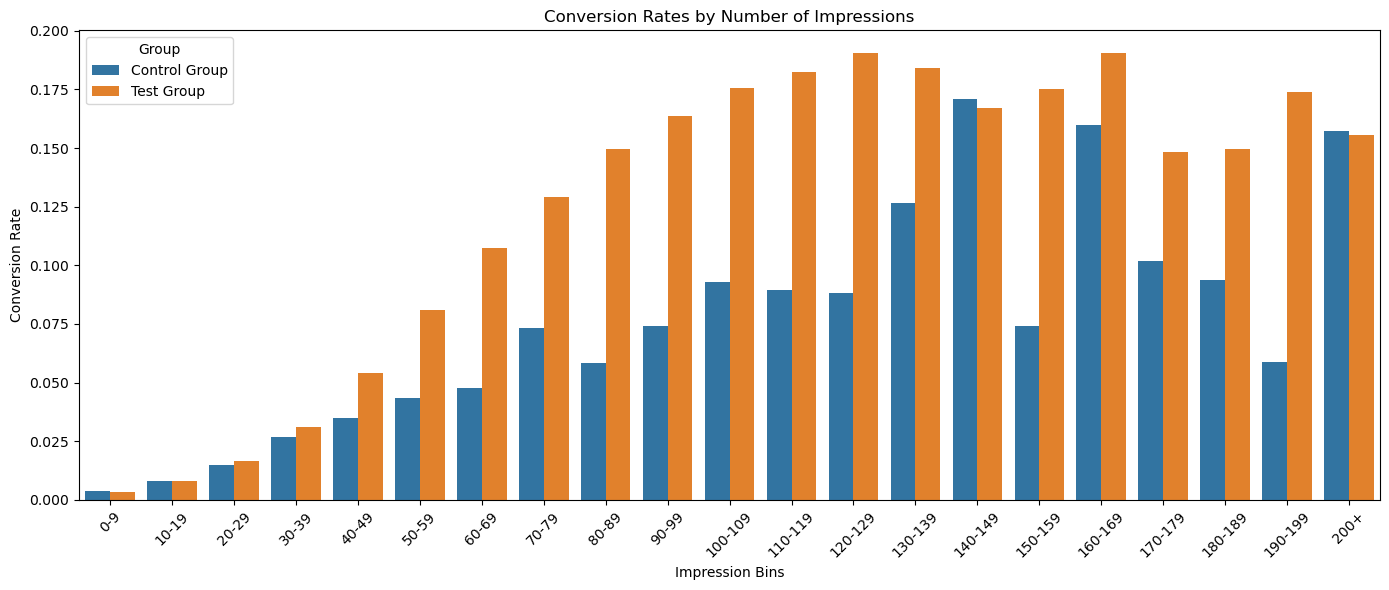

In [36]:
# Visualization: plot conversion rate comparison between control and test groups
plt.figure(figsize=(14, 6))
sns.barplot(data=conv_rate, x='impr_bin', y='converted', hue='Group')
plt.title("Conversion Rates by Number of Impressions")
plt.xlabel("Impression Bins")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()